In [1]:
import torch

In [2]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import random
from scipy.io import loadmat
from os import listdir
import torch.optim as optim

import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import math

from torchvision import models

In [3]:
from apex import amp

In [4]:
from tqdm.notebook import tqdm

In [5]:
torch.backends.cudnn.benchmark = True #might make it a tiny bit faster

In [6]:
DATA = Path("/data1/datasets/320")

In [7]:
PATH = Path("/data2/yinterian/imagenet_exp")

## Building blocks for resnet

In [8]:
def basicblock(in_, out_, kernel_size=3, stride=1, dilation=1, groups=1):
    padding = kernel_size//2
    block = nn.Sequential(nn.Conv2d(in_, out_, kernel_size, stride, padding, groups=groups, bias=False),
                          nn.BatchNorm2d(out_))    
    return block

In [9]:
class mainblock(nn.Module): 
    
    def __init__(self, in_, out_):  
        super(mainblock, self).__init__()
        self.apply_shortcut = not (in_ == out_)
        stride = 1
        if self.apply_shortcut:
            self.shortcut = basicblock(in_, out_, 1, 2)
            stride = 2
            
        self.layers = nn.Sequential(basicblock(in_, out_, 3, stride),
                                    nn.ReLU(inplace=True),
                                    basicblock(out_, out_, 3, 1)) 
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):     
        if self.apply_shortcut: 
            return self.relu(self.shortcut(x) + self.layers(x))
        else: 
            return self.relu(x + self.layers(x))

In [10]:
class resnet18(nn.Module): 
    def __init__(self, block=mainblock, num_classes=1000):
        
        super(resnet18, self).__init__()
        self.features1 = nn.Sequential(basicblock(3, 64, 7, 2),
                                       nn.ReLU(inplace=True), 
                                       nn.MaxPool2d(3, 2, 1), 
                                       block(64, 64),
                                       block(64, 64),
                                       block(64, 128),
                                       block(128, 128))
        self.features2 = nn.Sequential(block(128, 256),
                                       block(256, 256),
                                       block(256, 512),
                                       block(512, 512))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Data

In [11]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, rand_r, start_c, nr=300, nc=300):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    r_pix = (r - nr)//2
    c_pix = (c - nc)//2
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, nr, nc)

def center_crop(x, nr=300, nc=300):
    r, c,*_ = x.shape
    r_pix = (r - nr)//2
    c_pix = (c - nc)//2
    return crop(x, r_pix, c_pix, nr, nc)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [12]:
train_df = pd.read_csv(DATA/"train.csv")
valid_df = pd.read_csv(DATA/"valid.csv")

In [13]:
valid_df.head()

,x,y
0,val/n07754684/ILSVRC2012_val_00004497.JPEG,n07754684
1,val/n07754684/ILSVRC2012_val_00048298.JPEG,n07754684
2,val/n07754684/ILSVRC2012_val_00003664.JPEG,n07754684
3,val/n07754684/ILSVRC2012_val_00008662.JPEG,n07754684
4,val/n07754684/ILSVRC2012_val_00007563.JPEG,n07754684


In [14]:
path = DATA/train_df["x"][8]
path

PosixPath('/data1/datasets/320/train/n07754684/n07754684_12485.JPEG')

In [15]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

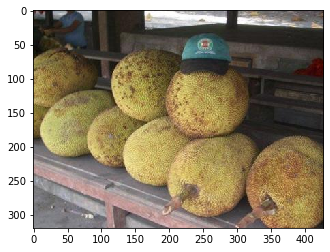

In [16]:
im = read_image(path)
plt.imshow(im)

(300, 300, 3)

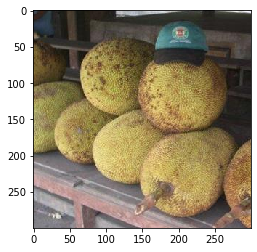

In [17]:
rand_r = random.uniform(0, 1)
rand_c = random.uniform(0, 1)
im2 = random_crop(im, rand_r, rand_c)
plt.imshow(im2); im2.shape

(300, 300, 3)

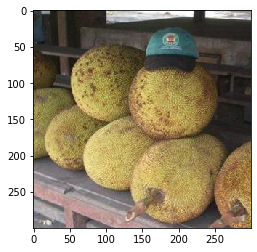

In [18]:
im2 = center_crop(im)
plt.imshow(im2); im2.shape

## Dataset

In [19]:
classes = np.sort(train_df["y"].unique())
class2id ={v:k for k,v in enumerate(classes)}

In [20]:
def apply_transforms(x, rand_arr, nr, nc):
    """ Applies a random crop, rotation"""
    rdeg = (rand_arr[0] -.50)*10
    x = rotate_cv(x, rdeg)
    if rand_arr[1] > 0.5: x = np.fliplr(x).copy() 
    x = random_crop(x, rand_arr[2], rand_arr[3], nr, nc)
    return x

In [21]:
class ImageNetDataSet(Dataset):
    def __init__(self, df, nr=300, transform=None):
        """
        Args:
            dataframe with data: image_file, label
            transform: if True apply transforms to images
        """
        self.image_files = df["x"].values
        self.labels = [class2id[y] for y in df["y"].values]
        self.transform = transform
        self.len = len(self.image_files)
        self.random_init()
        self.nr=nr
        
    def random_init(self):
        self.random = np.random.rand(self.len, 4)

    def __getitem__(self, index):
        path = DATA/self.image_files[index]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            x = apply_transforms(x, self.random[index], nr=self.nr, nc=self.nr)
        else:
            x = center_crop(x, nr=self.nr, nc=self.nr)
            
        y = self.labels[index]
        return np.rollaxis(x, 2), y

    def __len__(self):
        return self.len

In [22]:
train_df = pd.read_csv(DATA/"train.csv")
valid_df = pd.read_csv(DATA/"valid.csv")
train_ds = ImageNetDataSet(train_df, transform=True)
valid_ds = ImageNetDataSet(valid_df)

In [23]:
def normalize_tensors(x, y):
    # normalized 
    mean = torch.tensor([0.485 * 255, 0.456 * 255, 0.406 * 255]).cuda().view(1,3,1,1).half()
    std = torch.tensor([0.229 * 255, 0.224 * 255, 0.225 * 255]).cuda().view(1,3,1,1).half()
    x = x.half().cuda(non_blocking=True)
    return x.sub_(mean).div_(std), y.cuda(non_blocking=True)

## Training 

In [24]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [25]:
def LR_range_finder(model, optimizer, train_ds, train_dl, lr_low=1e-4, lr_high=0.1, epochs=1):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    pbar = tqdm(total=iterations)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    prev_loss = 0
    for i in range(epochs):
        train_ds.random_init()
        for x,y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x, y = normalize_tensors(x, y)
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()
            losses.append((prev_loss + loss.item())/2)
            prev_loss = loss.item()
            ind +=1
            pbar.update()
            
    load_model(model, str(p))
    return lrs[1:], losses[1:]

In [26]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/10, max_lr/100
    iter1 = int(0.2*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

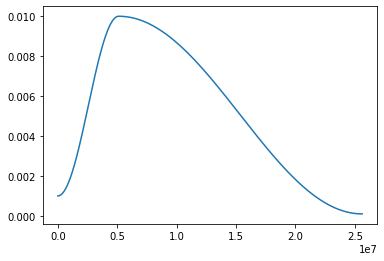

In [27]:
N = len(train_ds)*20
lr = get_cosine_triangular_lr(0.01, N)
plt.plot(list(range(N)), lr)
plt.show()

In [28]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in valid_dl:
            x, y = normalize_tensors(x, y)
            batch = y.shape[0]
            out = model(x)
            pred = torch.max(out, 1)[1]
            loss = F.cross_entropy(out, y)
            sum_loss += batch*(loss.item())
            total += batch
            correct += (pred == y).float().sum().item()
    
    return sum_loss/total, correct/total

In [29]:
def train_epoch(model, train_ds, train_dl, optimizer, lrs, idx, epoch, pbar):
    model.train()
    train_ds.random_init()
    total = 0
    sum_loss = 0
    for x,y in train_dl:
        lr = lrs[idx]
           
        update_optimizer(optimizer, [lr/4, lr/2, lr])
        x, y = normalize_tensors(x, y)
        batch = y.shape[0]
        out = model(x)
        loss = F.cross_entropy(out, y)
        optimizer.zero_grad()
        ## mixed precision
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()
        pbar.update()
        idx += 1
        total += batch
        sum_loss += batch*(loss.item())
    train_loss = sum_loss/total
    return train_loss, idx 

In [30]:
def train_a_few_epocs(model, optimizer, train_ds, train_dl, valid_dl, max_lr, epochs = 60, fixed_lr=False):
    
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    best_val_acc = 0.0
    idx = 0
    
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    if fixed_lr:
        lrs = [max_lr for i in range(iterations)]
    for i in range(epochs):
        print("using lr ", i, lrs[idx], idx)
        train_loss, idx = train_epoch(model, train_ds, train_dl, optimizer, lrs, idx, i, pbar)
        val_loss, val_acc = val_metric(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f \n" % 
              (train_loss, val_loss, val_acc))
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            path = "{0}/models/model_imagenet4_acc_{1:.0f}.pth".format(PATH, 100*val_acc) 
            save_model(model, path)
            print(path)

In [31]:
def create_optimizer(model, lr):
    params = [{'params': model.features1.parameters(), 'lr': lr},
              {'params': model.features2.parameters(), 'lr': lr},
              {'params': model.classifier.parameters(), 'lr': lr}]
    return optim.Adam(params, weight_decay=1e-5) # try 1e-4

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [34]:
model = resnet18().cuda()

In [35]:
load_model(model, "/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_68.pth")

In [36]:
optimizer = create_optimizer(model, 0.001)
# mixed precision
model, optimizer = amp.initialize(model, optimizer, opt_level="O2", 
                                      keep_batchnorm_fp32=True, loss_scale="dynamic")

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [37]:
batch_size = 700
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=10)
valid_dl = DataLoader(valid_ds, batch_size=batch_size//5, pin_memory=True, num_workers=10)

In [38]:
train_a_few_epocs(model, optimizer, train_ds, train_dl, valid_dl, max_lr=0.0005, epochs = 5, fixed_lr=True)

using lr  0 0.0005 0
train_loss 0.798 val_loss 1.379 val_acc 0.671 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_67.pth
using lr  1 0.0005 1831
train_loss 0.783 val_loss 1.384 val_acc 0.669 

using lr  2 0.0005 3662
train_loss 0.768 val_loss 1.392 val_acc 0.669 

using lr  3 0.0005 5493
train_loss 0.755 val_loss 1.408 val_acc 0.665 

using lr  4 0.0005 7324
train_loss 0.741 val_loss 1.418 val_acc 0.663 



In [38]:
train_a_few_epocs(model, optimizer, train_ds, train_dl, valid_dl, max_lr=0.01, epochs = 25)

using lr  0 0.0009999999999999992 0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
train_loss 4.401 val_loss 3.779 val_acc 0.228 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_23.pth
using lr  1 0.001859423525312735 1831
train_loss 2.907 val_loss 3.129 val_acc 0.330 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_33.pth
using lr  2 0.004109423525312736 3662
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
train_loss 2.414 val_loss 2.703 val_acc 0.405 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_41.pth
using lr  3 0.006890576474687264 5493
train_loss 2.226 val_loss 2.775 val_acc 0.394 

using lr  4 0.009140576474687263 7324
train_loss 2.139 val_loss 2.480 val_acc 0.441 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_44.pth
using lr  5 0.01 9155
train_loss 2.057 val_loss 2.387 val_acc 0.462 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_46.pth
using lr  6 0.00993905